In [1]:
# Neilsen Project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
sns.set(color_codes=True)
import functools
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
import pickle

#### read data

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
ideal= pd.read_csv("ideal.csv")
working=pd.read_csv('working.csv')

In [4]:
kirana=pd.read_csv("kirana_submit.csv")

In [6]:
kirana.info

<bound method DataFrame.info of           ID  TOTALVALUE
0       T375        3168
1       T379         323
2       T381         243
3       T382         994
4       T384         867
...      ...         ...
26980  T5999         403
26981  T6007         397
26982  T6007         606
26983  T6007         580
26984  T6013         430

[26985 rows x 2 columns]>

In [5]:
kirana['TOTALVALUE']=kirana['TOTALVALUE'].map(lambda x:int(x))kirana.head()


,ID,TOTALVALUE
0,T375,3168
1,T379,323
2,T381,243
3,T382,994
4,T384,867


In [7]:
kirana.mean()

TOTALVALUE    1303.669557
dtype: float64

In [9]:
kirana['TOTALVALUE']=np.where((kirana.TOTALVALUE<=1),1303,kirana.TOTALVALUE)

In [10]:
kirana.to_csv("kirana_submit.csv",index=False)

#### check null values in dataset

In [3]:
ideal.isnull().mean().sort_values(ascending=False)   # no null values in dataset
working.isnull().mean().sort_values(ascending=False)

BRD          0.0
MBRD         0.0
CMP          0.0
SSGRP        0.0
SGRP         0.0
GRP          0.0
PRICE        0.0
VALUE        0.0
QTY          0.0
BILL_AMT     0.0
BILL_ID      0.0
DAY          0.0
STORECODE    0.0
MONTH        0.0
dtype: float64

In [4]:
ideal_type=ideal.dtypes.reset_index()
ideal_type.columns=["count","column_type"]
ideal_type.groupby("column_type").aggregate("count").reset_index()

,column_type,count
0,int64,2
1,object,8


In [5]:
working_type=working.dtypes.reset_index()
working_type.columns=["count","column_type"]
working_type.groupby("column_type").aggregate("count").reset_index()

,column_type,count
0,int64,1
1,float64,4
2,object,9


In [6]:
ideal_grps= ideal.groupby(["GRP"])["QTY","VALUE"].aggregate({"QTY":'count',"VALUE":'sum'})
wrkg_grps= working.groupby(["GRP"])["QTY","VALUE"].aggregate({"QTY":'count',"VALUE":'sum'})
ideal_grps.columns=["QTYidl","VALidl"]
wrkg_grps.columns=["QTYwrk","VALwrk"]

In [7]:
idl_wrk_grps= pd.merge(ideal_grps,wrkg_grps,on="GRP",how="inner")
# groups removed during merge
lst1=list(ideal_grps.index)
lst2=list(idl_wrk_grps.index)
drp=[] # list of groups removed
for item in lst1:
    if item in lst2:
        pass
    else:
        print(item)
        drp.append(item)

CONFECTIONERY - JELLY CUBE
MOSQUITO REPELLANT EQUIP(4/97)


In [8]:
idl_wrk_grps.head()

,QTYidl,VALidl,QTYwrk,VALwrk
GRP,,,,
AFTER SHAVE LOTIONS,4,614,3,355.0
AGARBATTI & DHOOPBATTI,220,50302,118,6065.0
ALL AIR FRESHNERS(01/03),61,6956,86,11907.5
ALL IODISED SALT,88,58022,450,12138.5
ANTACIDS,30,9331,63,1509.6


#### data transformation for IDA

In [9]:
# log transformation
from feature_engine import variable_transformers as vt # import log_transformer
tf = vt.LogTransformer(variables = ['QTYidl','VALidl','QTYwrk','VALwrk']) # set up variable transformer
 
tf.fit(idl_wrk_grps) # fit the transformer
log_idl_wrk= tf.transform(idl_wrk_grps) # transform the data

In [10]:
# scaling the data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scale_log_data=scaler.fit_transform(log_idl_wrk)
scale_log_data=pd.DataFrame(scale_log_data)
scale_log_data.columns=log_idl_wrk.columns
stats.ttest_ind(scale_log_data.QTYidl,scale_log_data.QTYwrk) # t-test of distribution of ideal and working datasets

Ttest_indResult(statistic=-7.418656759157034e-16, pvalue=0.9999999999999994)

In [11]:
stats.ttest_ind(scale_log_data.VALidl,scale_log_data.VALwrk)

Ttest_indResult(statistic=-7.877906939485803e-15, pvalue=0.9999999999999937)

#### plotting the results

In [12]:
scale_log_data.index=log_idl_wrk.index # transferring the index values to the scaled data
scale_log_data.head()

,QTYidl,VALidl,QTYwrk,VALwrk
GRP,,,,
AFTER SHAVE LOTIONS,-2.388068,-1.898468,-2.217616,-1.861352
AGARBATTI & DHOOPBATTI,0.731776,0.611232,0.057451,-0.172280
ALL AIR FRESHNERS(01/03),-0.266891,-0.515756,-0.138539,0.229213
ALL IODISED SALT,0.018412,0.692563,0.886770,0.240647
ANTACIDS,-0.819398,-0.348433,-0.331354,-0.999917


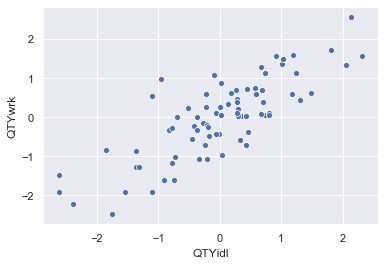

In [13]:
fig, ax = plt.subplots()
ax=sns.scatterplot(scale_log_data.QTYidl,scale_log_data.QTYwrk)

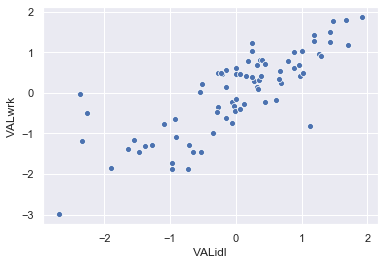

In [14]:
fig, ax = plt.subplots()
ax=sns.scatterplot(scale_log_data.VALidl,scale_log_data.VALwrk)

In [15]:
scale_log_data.corr()

,QTYidl,VALidl,QTYwrk,VALwrk
QTYidl,1.000000,0.815613,0.804319,0.627024
VALidl,0.815613,1.000000,0.870127,0.807067
QTYwrk,0.804319,0.870127,1.000000,0.893612
VALwrk,0.627024,0.807067,0.893612,1.000000


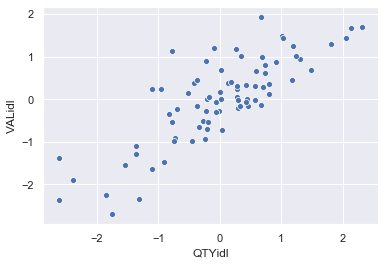

In [16]:
fig, ax = plt.subplots()
ax=sns.scatterplot(scale_log_data.QTYidl,scale_log_data.VALidl)

#### analysis of quantites sold

In [17]:
# quantites sold per month per store
ideal_store=ideal.groupby(["MONTH","STORECODE"])["QTY"].count().unstack()
a=ideal_store.std(axis=0)
b=ideal_store.mean(axis=0)
ideal_stat=pd.concat([a,b],axis=1)
ideal_stat.columns=["std","mean"]
ideal_stat["coeff_var"]= ideal_stat["std"]/ideal_stat["mean"]

ideal_stat.head()

,std,mean,coeff_var
STORECODE,,,
P1,19.553346,353.666667,0.055288
P10,23.028967,502.666667,0.045814
P2,16.502525,490.333333,0.033656
P3,35.679126,454.000000,0.078588
P4,16.165808,484.666667,0.033354


In [18]:
#quantites sold per month per store
working_store=working.groupby(["MONTH","STORECODE"])["QTY"].count().unstack()
a=working_store.std(axis=0)
b=working_store.mean(axis=0)
working_stat=pd.concat([a,b],axis=1)
working_stat.columns=["std","mean"]
working_stat["coeff_var"]=working_stat["std"]/working_stat["mean"]

working_stat.sort_values("mean").head()

,std,mean,coeff_var
STORECODE,,,
N8,137.502727,376.000000,0.365699
N6,409.146673,395.000000,1.035814
N2,94.775173,443.666667,0.213618
N9,364.489140,509.333333,0.715620
N3,225.867956,597.666667,0.377916


STORECODE     N1   N10    N2    N3    N4    N5   N6     N7    N8    N9
MONTH DAY                                                             
M1    1      0.0  23.0  30.0  35.0  56.0   0.0  5.0   74.0  21.0   0.0
      2      0.0   4.0  23.0   0.0  79.0  56.0  3.0   63.0  11.0  33.0
      3      0.0  10.0  20.0  71.0  40.0  43.0  4.0   76.0  11.0  46.0
      4    128.0   0.0  18.0  38.0  95.0  45.0  0.0  102.0   0.0  34.0
      5    120.0  13.0  39.0  41.0  24.0  34.0  0.0   79.0   2.0   0.0

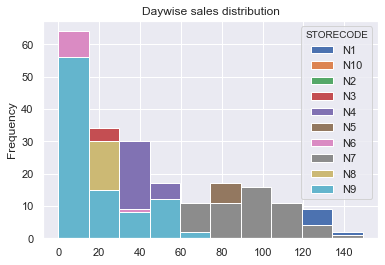

In [23]:
daywise=working.groupby(["MONTH","DAY","STORECODE"])["QTY"].count().unstack()
new_day=daywise.fillna(0)
new_day.plot.hist()
plt.title("Daywise sales distribution")
new_day.head()

In [24]:
# Number of days the stores were open
x=working.groupby(["STORECODE","MONTH"])["DAY"].unique()
zipped=zip(x.index,x.values) # zip the index and values of seperate lists in 1 tuple
lst=list(set(working.STORECODE))

for item in lst:       
    print(f"In 3 months store {item} was open for the following days below" )
    zipped=zip(x.index,x.values) # call zipped again each time as iterators cycle only once
    store2=[]
    for idx,val in zipped:          
        if item==idx[0]:
            sto=list(val)
            store2.append(len(sto))            
    print(functools.reduce(lambda a,b: a+b,store2)) # lambda sum function to find sum of items in list      
    

In 3 months store N3 was open for the following days below
64
In 3 months store N4 was open for the following days below
71
In 3 months store N5 was open for the following days below
68
In 3 months store N8 was open for the following days below
69
In 3 months store N10 was open for the following days below
75
In 3 months store N2 was open for the following days below
61
In 3 months store N1 was open for the following days below
68
In 3 months store N6 was open for the following days below
62
In 3 months store N9 was open for the following days below
57
In 3 months store N7 was open for the following days below
68


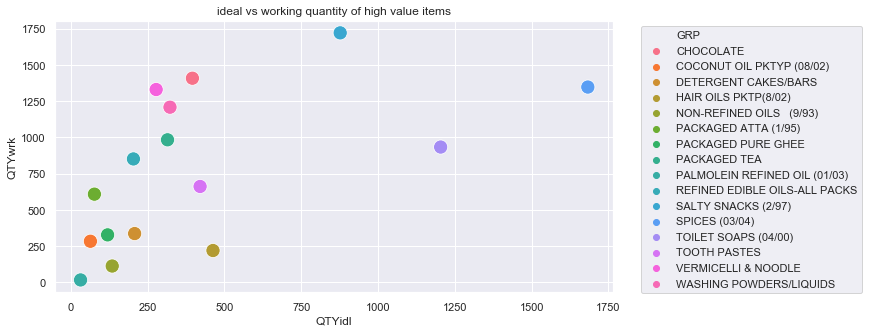

In [25]:
# plot comparison of quantity of items between ideal and working 
idl_grp=ideal.groupby('GRP')['QTY','VALUE'].aggregate({"QTY":"count","VALUE":"sum"})
wrk_grp=working.groupby('GRP')['QTY','VALUE'].aggregate({"QTY":"count","VALUE":"sum"})
idl_wrk_grp=pd.merge(idl_grp,wrk_grp,left_index=True,right_index=True,suffixes=["idl","wrk"])
rev=idl_wrk_grp.drop('BISCUITS - CORE & NON CORE')
high_idl_val=rev[rev.VALUEidl>80000]
import matplotlib.pyplot as plt
fig,axs=plt.subplots(1,1,figsize=(10,5))
ax=sns.scatterplot(high_idl_val.QTYidl,high_idl_val.QTYwrk,s=200,hue=high_idl_val.index)
plt.legend(bbox_to_anchor=(1.04,1),loc="best")# bbox_to_anchor sets legend outside plot
plt.title("ideal vs working quantity of high value items")
plt.savefig("high_quantity.png")

In [35]:
ideal.columns

Index(['MONTH', 'STORECODE', 'QTY', 'VALUE', 'GRP', 'SGRP', 'SSGRP', 'CMP',
       'MBRD', 'BRD'],
      dtype='object')

In [27]:
y_ideal=ideal[["VALUE"]]
X_ideal=ideal.drop(["SGRP","SSGRP","BRD","VALUE"],axis=1)

In [24]:
X_ideal.groupby(["MONTH","STORECODE"])["QTY"].count().unstack()

STORECODE,P1,P10,P2,P3,P4,P5,P6,P7,P8,P9
MONTH,,,,,,,,,,
M1,352,525,490,495,466,210,703,285,880,398
M2,374,504,507,437,494,213,702,282,896,407
M3,335,479,474,430,494,204,692,283,866,383


In [46]:
working.columns

Index(['MONTH', 'STORECODE', 'DAY', 'BILL_ID', 'BILL_AMT', 'QTY', 'VALUE',
       'PRICE', 'GRP', 'SGRP', 'SSGRP', 'CMP', 'MBRD', 'BRD'],
      dtype='object')

In [31]:
y_working=working[["VALUE"]]
X_working=working[["MONTH","STORECODE","QTY","GRP","CMP","MBRD"]]
# replace coding of working stores to match ideal stores
dict1={"N1":"P1","N2":"P2","N3":"P3","N4":"P4","N5":"P5","N6":"P6","N7":"P7","N8":"P8","N9":"P9","N10":"P10"}
X_working=X_working.replace(dict1)
X_working.head()

,MONTH,STORECODE,QTY,GRP,CMP,MBRD
0,M1,P1,1.0,BUTTER MARGR (4/94),G C M M F,AMUL
1,M1,P1,1.0,CONFECTIONERY - ECLAIRS,PARLE PRODS,MELODY
2,M1,P1,1.0,CHOCOLATE,MONDELEZ INTERNATIONAL,CADBURY SHOTS
3,M1,P1,1.0,PACKAGED TEA,GUJ TEA PROCESSORS,WAGH BAKRI
4,M1,P1,1.0,ALL IODISED SALT,TATA CHEM,TATA


#### splitting the ideal dataset into test and train for analysis

In [28]:
X_train, X_test, y_train, y_test = train_test_split (X_ideal, y_ideal, test_size = 0.3, 
                                                     random_state = 0)

#### Encode categorical values

In [55]:
# build encode object
import category_encoders as ce
encoder_hel = ce.HelmertEncoder(verbose=1,cols=["MONTH","STORECODE","GRP","CMP","MBRD"],return_df=True)
encoder_cat = ce.CatBoostEncoder(verbose=1,cols=["MONTH","STORECODE","GRP","CMP","MBRD"],return_df=True)

#### helmert encoding

In [40]:
X_train_hel=encoder_hel.fit_transform(X_train)
X_test_hel=encoder_hel.transform(X_test)
X_working_hel=encoder_hel.transform(X_working)

In [48]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
X_train_hel.shape,X_test_hel.shape

((9982, 1369), (4278, 1369))

#### scaling the dataset

In [42]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [148]:
X_train_hel=scaler.fit_transform(X_train_hel)
X_train_hel=pd.DataFrame(X_train_hel)
X_test_hel=scaler.transform(X_test_hel)
X_test_hel=pd.DataFrame(X_test_hel)
X_working_hel=scaler.transform(X_working_hel)
X_working_hel=pd.DataFrame(X_working_hel)
X_train_hel.shape,X_test_hel.shape

((9982, 1369), (4278, 1369))

#### catboost encoding

In [147]:
X_train_cat=encoder_cat.fit_transform(X_train,y_train)
X_test_cat=encoder_cat.transform(X_test,y_test)
X_working_cat=encoder_cat.transform(X_working,y_working)
type(X_test_cat)

pandas.core.frame.DataFrame

In [146]:
X_train_cat=scaler.fit_transform(X_train_cat)
X_train_cat=pd.DataFrame(X_train_cat)

X_test_cat = scaler.transform(X_test_cat) 
X_test_cat = pd.DataFrame(X_test_cat)

X_working_cat=scaler.transform(X_working_cat)
X_working_cat=pd.DataFrame(X_working_cat)
X_train_cat.shape, X_test_cat.shape, X_working_cat.shape

((9982, 6), (4278, 6), (26985, 6))

#### applying Xgboost


In [68]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error,r2_score

In [118]:
xg_reg=xgb.XGBRegressor(eval_metric="rmse",objective="reg:squarederror",colsample_bytree=0.3,learning_rate=0.2,max_depth=8,alpha=10,n_estimators=110)

In [119]:
# xgboost on helmert coded data
xg_reg.fit(X_train_hel,y_train)
ytrain_hel=xg_reg.predict(X_train_hel)
ytest_hel=xg_reg.predict(X_test_hel)
yworking_hel=xg_reg.predict(X_working_hel)

In [145]:
ytrain_hel.shape,ytest_hel.shape,yworking_hel.shape

((9982,), (4278,), (26985,))

In [121]:
# xgboost on catboost coded data
xg_reg.fit(X_train_cat,y_train)
ytrain_cat=xg_reg.predict(X_train_cat)
ytest_cat=xg_reg.predict(X_test_cat)
yworking_cat=xg_reg.predict(X_working_cat)
ytrain_cat.shape,ytest_cat.shape,yworking_cat.shape

((9982,), (4278,), (26985,))

#### Statitics of output by xgboost

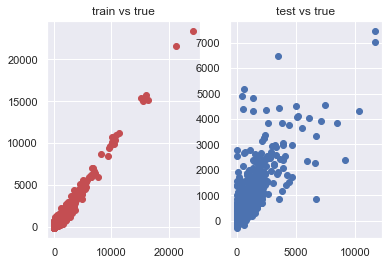

In [122]:
# analysis of xgboost predictions and helmert encoded data
fig,(ax1,ax2)=plt.subplots(1,2)

ax1.scatter(y_train.VALUE,ytrain_hel,color="r")
ax1.title.set_text("train vs true")
ax2.scatter(y_test.VALUE,ytest_hel,color="b")
ax2.title.set_text("test vs true")

In [124]:
# RMSE of train and test data
np.sqrt(mean_squared_error(y_train.VALUE,ytrain_hel)),np.sqrt(mean_squared_error(y_test.VALUE,ytest_hel))

(159.43580876796227, 381.312606116798)

In [123]:
# r2_score of train and test data
r2_score(y_train.VALUE,ytrain_hel,multioutput='uniform_average'),r2_score(y_test.VALUE,ytest_hel,multioutput='uniform_average')

(0.9603929530996608, 0.6604722352284049)

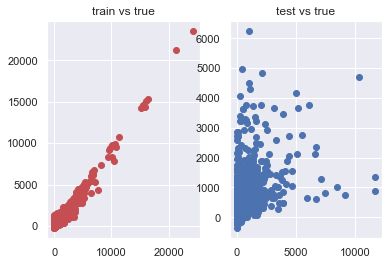

In [125]:
# analysis of xgboost predictions and catboost encoded data
fig,(ax1,ax2)=plt.subplots(1,2)

ax1.scatter(y_train.VALUE,ytrain_cat,color="r")
ax1.title.set_text("train vs true")
ax2.scatter(y_test.VALUE,ytest_cat,color="b")
ax2.title.set_text("test vs true")

In [126]:
# RSME of train and test data
np.sqrt(mean_squared_error(y_train.VALUE,ytrain_cat)),np.sqrt(mean_squared_error(y_test.VALUE,ytest_cat))

(225.58592409256784, 584.8895588171805)

In [127]:
# r2_score of train and test data
r2_score(y_train.VALUE,ytrain_cat,multioutput='uniform_average'),r2_score(y_test.VALUE,ytest_cat,multioutput='uniform_average')

(0.9207088495407331, 0.20115834054594595)

#### applying catboost algorithm

In [140]:
import numpy as np
from catboost import Pool, CatBoostRegressor as cbr

In [168]:
model = cbr(iterations=2000, 
                 depth=5, 
       learning_rate=0.2, 
     loss_function='RMSE',
           verbose=0)

In [169]:
# catboost on helmert coded data
model.fit(X_train_hel,y_train)
ytrain_hel=model.predict(X_train_hel)
ytest_hel=model.predict(X_test_hel)
yworking_hel=model.predict(X_working_hel)

In [170]:
ytrain_hel.shape,ytest_hel.shape,yworking_hel.shape

((9982,), (4278,), (26985,))

In [176]:
# catboost on catboost coded data
model.fit(X_train_cat,y_train)
ytrain_cat=model.predict(X_train_cat)
ytest_cat=model.predict(X_test_cat)
yworking_cat=model.predict(X_working_cat)

In [172]:
ytrain_cat.shape,ytest_cat.shape,yworking_cat.shape

((9982,), (4278,), (26985,))

#### statics of output bycatboost

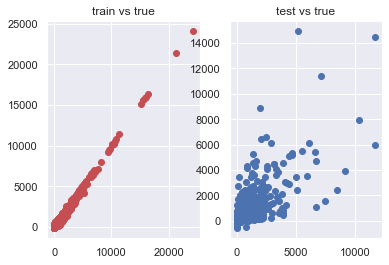

In [173]:
# analysis of catboost predictions and helmert encoded data
fig,(ax1,ax2)=plt.subplots(1,2)

ax1.scatter(y_train.VALUE,ytrain_cat,color="r")
ax1.title.set_text("train vs true")
ax2.scatter(y_test.VALUE,ytest_cat,color="b")
ax2.title.set_text("test vs true")

In [174]:
# RSME of train and test data
np.sqrt(mean_squared_error(y_train.VALUE,ytrain_hel)),np.sqrt(mean_squared_error(y_test.VALUE,ytest_hel))

(107.29435667222918, 255.80201865703577)

In [175]:
# r2_score of train and test data
r2_score(y_train.VALUE,ytrain_hel,multioutput='uniform_average'),r2_score(y_test.VALUE,ytest_hel,multioutput='uniform_average')

(0.982062806856074, 0.8472008625250254)

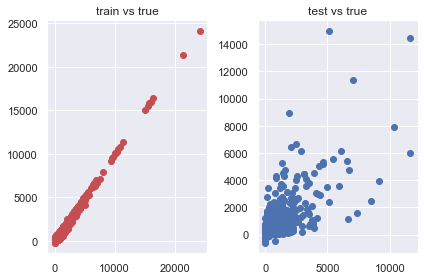

In [178]:
# analysis of catboost predictions and catboost encoded data
fig,(ax1,ax2)=plt.subplots(1,2)
ax1.scatter(y_train.VALUE,ytrain_cat,color="r")
ax1.title.set_text("train vs true")
ax2.scatter(y_test.VALUE,ytest_cat,color="b")
ax2.title.set_text("test vs true")
plt.tight_layout()

In [179]:
# RSME of train and test data
np.sqrt(mean_squared_error(y_train.VALUE,ytrain_cat)),np.sqrt(mean_squared_error(y_test.VALUE,ytest_cat))

(103.1415281539211, 472.2558321646807)

In [180]:
# r2_score of train and test data
r2_score(y_train.VALUE,ytrain_cat,multioutput='uniform_average'),r2_score(y_test.VALUE,ytest_cat,multioutput='uniform_average')

(0.9834244538228891, 0.4792040144153056)

#### final prediction of values for stores of working dataset

##### catboost on helmert coded data showed minimum RMSE and highest r2

In [181]:
# catboost on helmert coded data
model.fit(X_train_hel,y_train)
yworking_hel=model.predict(X_working_hel)

In [200]:
final_working=working.drop("VALUE",axis=1)
final_working.reset_index(inplace=True)

In [201]:
yfinal=pd.DataFrame(yworking_hel)
yfinal.columns=["VALUE"]
yfinal.shape,final_working.shape

((26985, 1), (26985, 14))

In [205]:
correct_working=final_working.join(yfinal)
correct_working.shape,working.shape

((26985, 15), (26985, 14))

In [208]:
correct_wrk_mnth=correct_working.groupby(["MONTH","STORECODE"])[""]

,MONTH,STORECODE,DAY,BILL_ID,BILL_AMT,QTY,PRICE,GRP,SGRP,SSGRP,CMP,MBRD,BRD,VALUE
0,M1,N1,4,T375,225.0,1.0,225.0,BUTTER MARGR (4/94),BUTTER,SALTED,G C M M F,AMUL,AMUL,3168.338304
1,M1,N1,4,T379,95.0,1.0,95.0,CONFECTIONERY - ECLAIRS,CONFECTIONERY - ECLAIRS,CONFECTIONERY - ECLAIRS,PARLE PRODS,MELODY,MELODY CHOCOLATY,323.115974
2,M1,N1,4,T381,10.0,1.0,10.0,CHOCOLATE,CHOCOLATE PANNED,CHOCOLATE PANNED,MONDELEZ INTERNATIONAL,CADBURY SHOTS,CADBURY SHOTS,243.510513
3,M1,N1,4,T382,108.0,1.0,108.0,PACKAGED TEA,MAIN PACKS,MAIN PACKS,GUJ TEA PROCESSORS,WAGH BAKRI,WAGH BAKRI INSTANT,994.968639
4,M1,N1,4,T384,19.0,1.0,19.0,ALL IODISED SALT,POWDERED SALT,POWDERED SALT,TATA CHEM,TATA,TATA SALT,867.529530


In [213]:
wrk_grp=correct_working.groupby(['MONTH','GRP','STORECODE'])['QTY','VALUE'].aggregate({"QTY":"count","VALUE":"sum"}).unstack()

In [221]:
wrk_grp=wrk_grp.fillna(0)
wrk_grp.head()

QTY                                        \
STORECODE                         N1   N10   N2    N3   N4   N5   N6    N7   
MONTH GRP                                                                    
M1    AFTER SHAVE LOTIONS        0.0   0.0  0.0   0.0  1.0  0.0  0.0   0.0   
      AGARBATTI & DHOOPBATTI     5.0   1.0  6.0   4.0  1.0  2.0  0.0   8.0   
      ALL AIR FRESHNERS(01/03)   3.0   0.0  5.0   1.0  3.0  1.0  0.0   6.0   
      ALL IODISED SALT          29.0  14.0  2.0  13.0  2.0  1.0  0.0  43.0   
      ANTACIDS                   6.0   2.0  1.0   1.0  0.0  0.0  0.0   7.0   

                                                  VALUE                \
STORECODE                        N8    N9            N1           N10   
MONTH GRP                                                               
M1    AFTER SHAVE LOTIONS       1.0   0.0      0.000000      0.000000   
      AGARBATTI & DHOOPBATTI    0.0   2.0   6138.315371   1009.610321   
      ALL AIR FRESHNERS(01/03)  2.0   2.0   1996.290680      0.000000   
      ALL IODISED SALT          2.0  31.0  25507.393229  13605.436147   
      ANTACIDS                  0.0   0.0   2889.709542   1221.575104   

                                                                        \
STORECODE                                N2            N3           N4   
MONTH GRP                                                                
M1    AFTER SHAVE LOTIONS          0.000000      0.000000   397.933734   
      AGARBATTI & DHOOPBATTI    7981.019140   3675.391209  1095.149328   
      ALL AIR FRESHNERS(01/03)  5577.679220    745.379543  2505.357293   
      ALL IODISED SALT          1447.872172  14731.167192  1634.417419   
      ANTACIDS                   410.850424    354.407464     0.000000   

                                                                             \
STORECODE                                N5   N6            N7           N8   
MONTH GRP                                                                     
M1    AFTER SHAVE LOTIONS          0.000000  0.0      0.000000   530.612983   
      AGARBATTI & DHOOPBATTI    2282.351827  0.0  10732.771167     0.000000   
      ALL AIR FRESHNERS(01/03)   630.911492  0.0   6070.713097  1839.726056   
      ALL IODISED SALT           653.585650  0.0  52985.223457  2949.734502   
      ANTACIDS                     0.000000  0.0   4174.888942     0.000000   

                                              
STORECODE                                 N9  
MONTH GRP                                     
M1    AFTER SHAVE LOTIONS           0.000000  
      AGARBATTI & DHOOPBATTI     2480.528386  
      ALL AIR FRESHNERS(01/03)   2311.963407  
      ALL IODISED SALT          27838.590075  
      ANTACIDS                      0.000000

In [216]:
correct_working.to_csv("C:\\Users\\anubr\\Documents\\neilsen_challenge\\Kirana_Grp.csv",index=False)

In [222]:
wrk_grp.to_csv("C:\\Users\\anubr\\Documents\\neilsen_challenge\\Kirana_Grp.csv",index=True)